### Description: Predicting the direction of Stocks price using stock indicators with machine learning.
- Technical Indicators: They are mathematical calculations based on things like the stock price or the stock volume.
- Technical analysts and traders use these indicators and historical data to try and predict future price movements.

Importing Libraries

In [359]:
import pandas as pd
import numpy as np
import pandas_datareader as web
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

Get the stock quote

In [360]:
df = web.DataReader('UBER', data_source = 'yahoo', start = '2020-01-01', end = '2021-02-10')

Showing the starting 5 data 

In [361]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-02,31.000000,29.790001,29.940001,30.990000,20578900,30.990000
2020-01-03,31.430000,30.480000,30.620001,31.370001,18822700,31.370001
2020-01-06,32.060001,31.000000,31.010000,31.580000,21204700,31.580000
2020-01-07,32.840000,31.360001,31.790001,32.810001,30119600,32.810001
2020-01-08,34.520000,32.459999,32.730000,33.930000,43944400,33.930000


Get the number of rows and columns in the data set

In [362]:
df.shape

(280, 6)

Visualize the closing price history

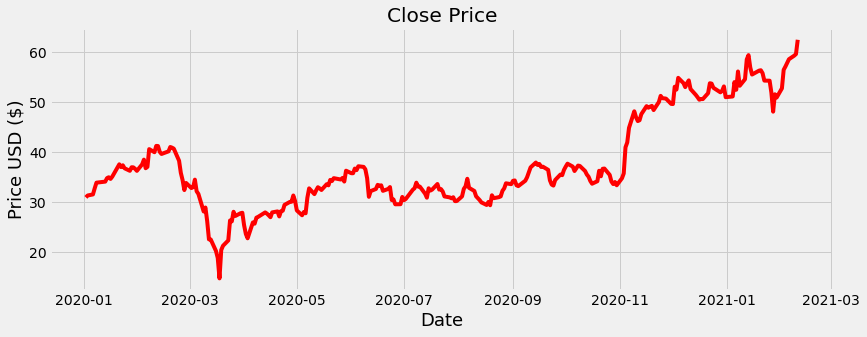

In [363]:
plt.figure(figsize = (12.5, 4.5))
plt.plot(df['Close'], label = 'Close', color = 'red')
plt.title('Close Price')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Price USD ($)', fontsize = 18)
plt.show()

Creating Functions to calculate the SMA and EMA
- SMA: Simple Moving Average
   
   
   *A simple moving average (SMA) calculates the average of a selected range of prices, usually closing prices, by the number of periods in that range. A simple moving average is a technical indicator that can aid in determining if an asset price will continue or if it will reverse a bull or bear trend.* (source: google Jan 27,2021)
- EMA: Exponential Moving Average

*The exponential moving average (EMA) is a technical chart indicator that tracks the price of an investment (like a stock or commodity) over time. The EMA is a type of weighted moving average (WMA) that gives more weighting or importance to recent price data.*
(source: google Jan 27,2021)

-  a common time period to use for moving averages are 15, 20, 30, 50, 100 and 200 days.


1st Creating the Simple Moving Average (SMA)


In [364]:
def SMA(data, period=30, column='Close'):
  return data[column].rolling(window=period).mean()

2nd Creating the Exponential Moving Average (EMA)

In [365]:
def EMA(data, period=20, column='Close'):
  return data[column].ewm(span=period, adjust=False).mean()

Calculating the MACD
- MACD: Moving Average Convergence/Divergence

*Moving average convergence divergence (MACD) is a trend-following momentum indicator that shows the relationship between two moving averages of a security's price. ... Traders may buy the security when the MACD crosses above its signal line and sell—or short—the security when the MACD crosses below the signal line.* (source: Jan 27,2021)
- longer period has a 26 day exponential moving average. 
- shorter period has a 20 day exponential moving average.
- MACD also have a signal line which is recommended to have a 9 day exponential moving average.



In [366]:
def MACD(data, period_long=26, period_short=12, period_signal=9, column='Close'):
  
  #Calculating the Short Term Exponential Moving Average
  ShortEMA = EMA(data, period_short, column=column)

  #Calculating the Long Term Exponential Moving Average
  LongEMA = EMA(data, period_long, column=column)

  #Calculating the Moving Average Convergence/Divergence (MACD)
  data['MACD'] = ShortEMA - LongEMA

  #Calculating the signal line
  data['Signal_line'] = EMA(data, period_signal, column='MACD')

  return data

Creating a function for computing the RSI
- RSI: Relative Strength Index

*The relative strength index (RSI) is a momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset.* (source: Jan 27,2021)
-  Here defaulting to recommended 14 day time period.
- diff function is used to find the discrete difference over the column axis.

In [367]:
def RSI(data, period=14, column='Close'):
  delta = data[column].diff(1)
  delta = delta.dropna()
  up = delta.copy()
  down = delta.copy()
  up[up < 0] = 0
  down[down > 0] = 0
  data['up'] = up
  data['down'] = down
  AVG_Gain = SMA(data, period, column='up')
  AVG_Loss = abs(SMA(data, period, column='down'))
  RS = AVG_Gain / AVG_Loss
  RSI = 100.0 - (100.0/(1.0 + RS))

  data['RSI'] = RSI

  return data

Creating/Adding the data set

In [368]:
MACD(df)
RSI(df)
df['SMA'] = SMA(df)
df['EMA'] = EMA(df)

Showing the  data

In [369]:
df

,High,Low,Open,Close,Volume,Adj Close,MACD,Signal_line,up,down,RSI,SMA,EMA
Date,,,,,,,,,,,,,
2020-01-02,31.000000,29.790001,29.940001,30.990000,20578900,30.990000,0.000000,0.000000,NaN,NaN,NaN,NaN,30.990000
2020-01-03,31.430000,30.480000,30.620001,31.370001,18822700,31.370001,0.030313,0.006063,0.380001,0.0,NaN,NaN,31.026190
2020-01-06,32.060001,31.000000,31.010000,31.580000,21204700,31.580000,0.070470,0.018944,0.209999,0.0,NaN,NaN,31.078934
2020-01-07,32.840000,31.360001,31.790001,32.810001,30119600,32.810001,0.199248,0.055005,1.230001,0.0,NaN,NaN,31.243798
2020-01-08,34.520000,32.459999,32.730000,33.930000,43944400,33.930000,0.387217,0.121447,1.119999,0.0,NaN,NaN,31.499626
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-04,57.849998,56.110001,56.450001,57.849998,13841600,57.849998,0.680298,0.484439,0.730000,0.0,52.179960,54.152000,54.280914
2021-02-05,58.708000,57.369999,58.160000,58.580002,15705700,58.580002,0.944314,0.576414,0.730003,0.0,57.320576,54.312000,54.690351
2021-02-08,60.110001,58.689999,59.700001,59.290001,18403700,59.290001,1.197041,0.700539,0.709999,0.0,57.177150,54.498000,55.128413


Creating the target column
- In the target column we want to know if tomorrow's price will go up or down, so for doing that we can basically use zero(0) or one(1).
- One will indicate that, tomorrow's closed price will be higher than today's closed price and a zero indicates tomorrow's close price will be equal to or lower than today's closed price.

In [370]:
df['Target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

Showing the data

In [371]:
df

,High,Low,Open,Close,Volume,Adj Close,MACD,Signal_line,up,down,RSI,SMA,EMA,Target
Date,,,,,,,,,,,,,,
2020-01-02,31.000000,29.790001,29.940001,30.990000,20578900,30.990000,0.000000,0.000000,NaN,NaN,NaN,NaN,30.990000,1
2020-01-03,31.430000,30.480000,30.620001,31.370001,18822700,31.370001,0.030313,0.006063,0.380001,0.0,NaN,NaN,31.026190,1
2020-01-06,32.060001,31.000000,31.010000,31.580000,21204700,31.580000,0.070470,0.018944,0.209999,0.0,NaN,NaN,31.078934,1
2020-01-07,32.840000,31.360001,31.790001,32.810001,30119600,32.810001,0.199248,0.055005,1.230001,0.0,NaN,NaN,31.243798,1
2020-01-08,34.520000,32.459999,32.730000,33.930000,43944400,33.930000,0.387217,0.121447,1.119999,0.0,NaN,NaN,31.499626,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-04,57.849998,56.110001,56.450001,57.849998,13841600,57.849998,0.680298,0.484439,0.730000,0.0,52.179960,54.152000,54.280914,1
2021-02-05,58.708000,57.369999,58.160000,58.580002,15705700,58.580002,0.944314,0.576414,0.730003,0.0,57.320576,54.312000,54.690351,1
2021-02-08,60.110001,58.689999,59.700001,59.290001,18403700,59.290001,1.197041,0.700539,0.709999,0.0,57.177150,54.498000,55.128413,1


Removing the first 29 days of data 
- To get rid of some null or nan value in the data set

In [372]:
df = df[29:]

Showing the data

In [373]:
df

,High,Low,Open,Close,Volume,Adj Close,MACD,Signal_line,up,down,RSI,SMA,EMA,Target
Date,,,,,,,,,,,,,,
2020-02-13,41.549999,40.000000,40.930000,40.090000,23850900,40.090000,1.816856,1.599386,0.000000,-1.160000,62.881761,36.261333,37.839880,0
2020-02-14,40.310001,38.700001,40.020000,39.660000,32014200,39.660000,1.738078,1.627125,0.000000,-0.430000,63.228352,36.550333,38.013225,1
2020-02-18,40.270000,39.450001,39.490002,40.180000,22149300,40.180000,1.698031,1.641306,0.520000,0.000000,62.669874,36.844000,38.219584,1
2020-02-19,41.230000,40.115002,40.419998,41.049999,23287300,41.049999,1.716706,1.656386,0.869999,0.000000,65.194601,37.159667,38.489148,0
2020-02-20,41.189999,39.849998,41.000000,40.919998,25446400,40.919998,1.701403,1.665389,0.000000,-0.130001,66.084969,37.430000,38.720657,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-04,57.849998,56.110001,56.450001,57.849998,13841600,57.849998,0.680298,0.484439,0.730000,0.000000,52.179960,54.152000,54.280914,1
2021-02-05,58.708000,57.369999,58.160000,58.580002,15705700,58.580002,0.944314,0.576414,0.730003,0.000000,57.320576,54.312000,54.690351,1
2021-02-08,60.110001,58.689999,59.700001,59.290001,18403700,59.290001,1.197041,0.700539,0.709999,0.000000,57.177150,54.498000,55.128413,1


Splitting the data set into the feature or independent data set (X) and a Target or dependent data set (Y)

In [374]:
keep_columns = ['Close', 'MACD', 'Signal_line', 'RSI', 'SMA', 'EMA']
X = df[keep_columns].values
Y = df['Target'].values

Going to split data set again but this time we are going to split it into training data set (80%) and testing data sets (20%)

In [375]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 2)

Creating and train the decision tree classifier model

In [376]:
tree = DecisionTreeClassifier().fit(X_train, Y_train)

Checking how well the model did on the training data set

In [377]:
print(tree.score(X_train, Y_train))

1.0


Checking how well the model did on the testing data set

In [378]:
print(tree.score(X_test, Y_test))

0.6078431372549019


Showing the model tree predictions

In [379]:
tree_predictions = tree.predict(X_test)
print(tree_predictions)

[1 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 0
 1 1 1 1 0 0 0 1 1 1 1 0 0 0]


Showing the actual values from the test data 

In [380]:
Y_test

array([1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 0])

Getting the models metrics

In [381]:
print(classification_report(Y_test, tree_predictions))

              precision    recall  f1-score   support

           0       0.60      0.50      0.55        24
           1       0.61      0.70      0.66        27

    accuracy                           0.61        51
   macro avg       0.61      0.60      0.60        51
weighted avg       0.61      0.61      0.60        51



This model is promising for exploring more on machine learing classifiers for stock price movements and may be the model can be improved upon with the use of other indicators, more data, parameter tuning and definately some more analysis.


# COMPELETE